In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.augment.spectrogram import CropTime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything(1234)

In [5]:
FOLD=2

In [6]:
path = Path("/home/kkalyan/agri-split/data")
df = pd.read_csv(path/"Train_v.csv")

In [7]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [8]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [9]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock), 
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 splitter=CrossValidationSplitter(fold=FOLD),
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise(), ChangeVolume(), SignalLoss()],
                 get_y=ColReader("label"))

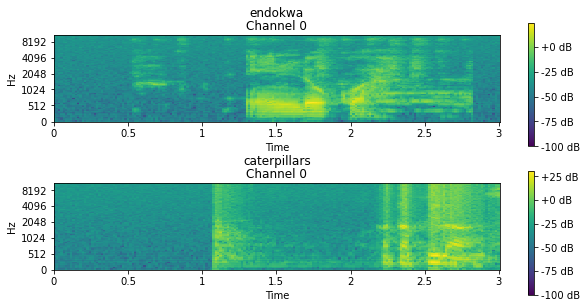

In [10]:
dbunch = auds.dataloaders(df, bs=128)
dbunch.show_batch(figsize=(10, 5))

In [11]:
learn = cnn_learner(dbunch, 
            resnet18, 
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy]).to_fp16()

In [12]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,7.162242,6.793617,0.005405,00:03


epoch,train_loss,valid_loss,accuracy,time
0,7.110988,5.986704,0.010811,00:04
1,7.111924,5.813550,0.005405,00:04
2,7.052103,5.825012,0.008108,00:05


In [13]:
learn.fit_one_cycle(150, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,6.778011,5.759278,0.016216,00:05
1,6.717583,5.740147,0.005405,00:05
2,6.727239,5.762296,0.005405,00:04
3,6.692059,5.771389,0.013514,00:04
4,6.638437,5.694702,0.008108,00:04
5,6.593857,5.661372,0.013514,00:04
6,6.532389,5.643526,0.002703,00:04
7,6.462640,5.565560,0.018919,00:03
8,6.390023,5.611072,0.013514,00:04
9,6.292925,5.569541,0.018919,00:04


Better model found at epoch 0 with valid_loss value: 5.759277820587158.
Better model found at epoch 1 with valid_loss value: 5.740147113800049.
Better model found at epoch 4 with valid_loss value: 5.694701671600342.
Better model found at epoch 5 with valid_loss value: 5.66137170791626.
Better model found at epoch 6 with valid_loss value: 5.643526077270508.
Better model found at epoch 7 with valid_loss value: 5.565560340881348.
Better model found at epoch 11 with valid_loss value: 5.5305962562561035.
Better model found at epoch 12 with valid_loss value: 5.515068054199219.
Better model found at epoch 13 with valid_loss value: 5.442697048187256.
Better model found at epoch 14 with valid_loss value: 5.2420830726623535.
Better model found at epoch 15 with valid_loss value: 5.053871154785156.
Better model found at epoch 16 with valid_loss value: 4.860823154449463.
Better model found at epoch 17 with valid_loss value: 4.671682357788086.
Better model found at epoch 19 with valid_loss value: 4.

In [14]:
ac_1 = learn.validate(); ac_1

(#2) [3.1142280101776123,0.39729729294776917]

In [15]:
#Better model found at epoch 82 with valid_loss value: 3.824885606765747.

In [16]:
# (#2) [3.856053113937378,0.25135135650634766]